# LG M50 Single Pulse Parameter Identification
## Validating the ECM parameters identified from a single pulse

This example presents an experimental parameter identification method for a two-RC circuit model. The data for this notebook is located within the same directory and was obtained from WDWidanage/Simscape-Battery-Library [[1]](https://github.com/WDWidanage/Simscape-Battery-Library/tree/a3842b91b3ccda006bc9be5d59c8bcbd167ceef7/Examples/parameterEstimation_TECMD/Data).


### Setting up the Environment

If you don't already have PyBOP installed, check out the [installation guide](https://pybop-docs.readthedocs.io/en/latest/installation.html) first.

We begin by upgrading some dependencies and importing the necessary libraries. We will use Pandas for data ingestion and manipulation. Let's also fix the random seed to generate consistent output during development. 

In [ ]:
%pip install --upgrade pip pandas -q

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybamm
from scipy.io import loadmat

import pybop

go = pybop.plot.PlotlyManager().go
pybop.plot.PlotlyManager().pio.renderers.default = "notebook_connected"

np.random.seed(8)  # users can remove this line

## Importing Data

The data is imported as a dictionary with the following key level:
- ["LGM50_5Ah_Pulse"]
    - Temperature-> ["T0"]
        - State of Charge ->["SoC3"]
            - Cell number -> ["Cell1"]
                - Corresponding data -> ["data"]

Using SciPy's `loadmat`, we import the data from the MAT containers:

In [ ]:
ocp = loadmat(
    "../../data/LG_M50_ECM/data/LGM50_5Ah_OCV.mat", simplify_cells=True, mat_dtype=False
)
pulse_data = loadmat(
    "../../data/LG_M50_ECM/data/LGM50_5Ah_Pulse.mat",
    simplify_cells=True,
    mat_dtype=False,
)
rate_data = loadmat(
    "../../data/LG_M50_ECM/data/LGM50_5Ah_RateTest.mat",
    simplify_cells=True,
    mat_dtype=False,
)

### Convert to Dataframes

Next, we construct a dataframe from a selected pulse. In this case, we select the data for zero degrees (`T0`) with a state-of-charge of 90% (`SoC9`) and the 19th cell (`Cell19`). This can be extended to multiple pulses, or a different selection.

Additionally, we apply two filters to the dataframe to ensure the data contains only monotonically increasing time samples without duplicates.

In [ ]:
df = pd.DataFrame(pulse_data["LGM50_5Ah_Pulse"]["T0"]["SoC9"]["Cell19"]["data"])
df["ProgTime"] = df["ProgTime"] - df["ProgTime"].min()
df.drop_duplicates(subset=["ProgTime"], inplace=True)

A plot of voltage vs. time confirms the data looks as expected for fitting. In this situation, we would prefer to have additional samples from the relaxation, but as we will show below, PyBOP is still able to identify parameter values that fit this system.

In [ ]:
go.Figure(
    data=go.Scatter(x=df["ProgTime"], y=df["Voltage"]),
    layout=go.Layout(xaxis_title="Time / s", yaxis_title="Voltage / V"),
)

We can now form the `pybop.Dataset` from the experimental data. In this situation, the applied current convention is different between the experimental data and PyBOP's convention. This is solved by negating the vector on construction.

In [ ]:
dataset = pybop.Dataset(
    {
        "Time [s]": df["ProgTime"].values,
        "Current function [A]": -df["Current"].values,
        "Voltage [V]": df["Voltage"].values,
    }
)

Next, we construct the OCV function from the imported OCV data. This is completed with a wrapper method on the `pybamm.Interpolant` function,

In [ ]:
def ocv_LGM50(sto):
    name = "OCV"
    x = (ocp["LGM50_5Ah_OCV"]["T25"]["refSoC"].reshape(-1) / 100,)
    y = ocp["LGM50_5Ah_OCV"]["T25"]["meanOCV"].reshape(-1)
    return pybamm.Interpolant(x, y, sto, name)

We can construct the parameter values for a two-RC circuit model with initial values as listed below. Note, the "Initial SOC" is shifted slightly to better match the zero degree data.

In [ ]:
params = pybamm.ParameterValues(
    {
        "chemistry": "ecm",
        "Initial SoC": 0.9 - 0.01,
        "Initial temperature [K]": 25 + 273.15,
        "Cell capacity [A.h]": 5,
        "Nominal cell capacity [A.h]": 5,
        "Ambient temperature [K]": 25 + 273.15,
        "Current function [A]": 4.85,
        "Upper voltage cut-off [V]": 4.2,
        "Lower voltage cut-off [V]": 3.0,
        "Cell thermal mass [J/K]": 1000,
        "Cell-jig heat transfer coefficient [W/K]": 10,
        "Jig thermal mass [J/K]": 500,
        "Jig-air heat transfer coefficient [W/K]": 10,
        "Open-circuit voltage [V]": ocv_LGM50,
        "R0 [Ohm]": 0.005,
        "Element-1 initial overpotential [V]": 0,
        "Element-2 initial overpotential [V]": 0,
        "R1 [Ohm]": 0.0001,
        "R2 [Ohm]": 0.0001,
        "C1 [F]": 3000,
        "C2 [F]": 6924,
        "Entropic change [V/K]": 0.0004,
    }
)

Next we construct the model class with two RC elements.

In [ ]:
model = pybamm.equivalent_circuit.Thevenin(options={"number of rc elements": 2})

## Identifying the parameters

Now that the initial parameter values and model are defined, we can start the PyBOP fitting process. In this example, we are going to try to fit all five resistance and capacitance parameters at once. To do this, we define a `pybop.Parameter` for each fitting parameter and compile them into a list.

In [ ]:
parameters = [
    pybop.Parameter(
        "R0 [Ohm]",
        prior=pybop.Gaussian(0.005, 0.0001),
        bounds=[1e-6, 2e-1],
    ),
    pybop.Parameter(
        "R1 [Ohm]",
        prior=pybop.Gaussian(0.0001, 0.0001),
        bounds=[1e-6, 1],
    ),
    pybop.Parameter(
        "R2 [Ohm]",
        prior=pybop.Gaussian(0.0001, 0.0001),
        bounds=[1e-6, 1],
    ),
    pybop.Parameter(
        "C1 [F]",
        prior=pybop.Gaussian(3000, 2500),
        bounds=[0.5, 1e4],
    ),
    pybop.Parameter(
        "C2 [F]",
        prior=pybop.Gaussian(3000, 2500),
        bounds=[0.5, 1e4],
    ),
]

We first define a builder and then use it to build the optimisation problem that we need to evaluate our selected `SumSquaredError` cost function. 

In [ ]:
# Construct the problem builder
builder = (
    pybop.builders.Pybamm()
    .set_dataset(dataset)
    .set_simulation(model, parameter_values=params)
    .add_cost(pybop.costs.pybamm.SumSquaredError("Voltage [V]", "Voltage [V]"))
)
for param in parameters:
    builder.add_parameter(param)
problem = builder.build()

The cost function can be interrogated manually. In this example, that would look like the following,

In [ ]:
problem.set_params([0.01, 0.01, 0.01, 20000, 20000])
cost = problem.run()
print("Cost:", cost)

Cost: [1.17670725]


Next, we construct the optimisation class with our algorithm of choice and run it. In this case, we select the PSO method as it provides global optimisation capability. After optimisation, we can compare the initial parameters to the identified parameters.

In [ ]:
options = pybop.PintsOptions(
    max_unchanged_iterations=55,
    threshold=1e-6,
)
optim = pybop.PSO(problem, options=options)
results = optim.run()

## Plotting and validation

PyBOP provides various plotting utilities to visualise the results of the optimisation. This time, let's look at the fitting results and validation against a second dataset.

Here we compare the optimised model prediction against the original dataset.

In [ ]:
identified_parameter_values = results.parameter_values
sim = pybamm.Simulation(model, parameter_values=identified_parameter_values)
t_eval = dataset["Time [s]"]
sol = sim.solve(t_eval=t_eval)
pybop.plot.trajectories(
    x=t_eval,
    y=[dataset["Voltage [V]"], sol["Voltage [V]"](t_eval)],
    trace_names=["Dataset", "Simulation"],
    xaxis_title="Time / s",
    yaxis_title="Voltage / V",
);

We've identified parameters from a single discharge pulse. Now, let's ask ourselves how well these parameters extrapolate to other operational conditions. To accomplish this, let's load a new pulse dataset at 80% SOC and compare it to our identified forward model.

In [ ]:
df_pulse_two = pd.DataFrame(
    pulse_data["LGM50_5Ah_Pulse"]["T0"]["SoC8"]["Cell19"]["data"]
)
df_pulse_two["ProgTime"] = df_pulse_two["ProgTime"] - df_pulse_two["ProgTime"].min()
df_pulse_two.drop_duplicates(subset=["ProgTime"], inplace=True)

Now that we have a new dataset, we update the "Current function [A]" as well as the "Initial SoC" value. Once that has been completed, we re-run the simulation.

In [ ]:
# Extract time and current values from the second pulse dataset
t_exp = df_pulse_two["ProgTime"].values
i_exp = -df_pulse_two["Current"].values

# Create a pybamm input current function
current_interpolant = pybamm.Interpolant(t_exp, i_exp, pybamm.t)

# Update the identified parameter values with a new SOC and current function
identified_parameter_values.set_initial_state(0.8 - 0.0075)
identified_parameter_values.update({"Current function [A]": current_interpolant})

# Create and solve a simulation with the updated parameters
sim = pybamm.Simulation(model, parameter_values=identified_parameter_values)
sol = sim.solve(t_eval=t_exp)

Let's plot the simulation against the new pulse data:

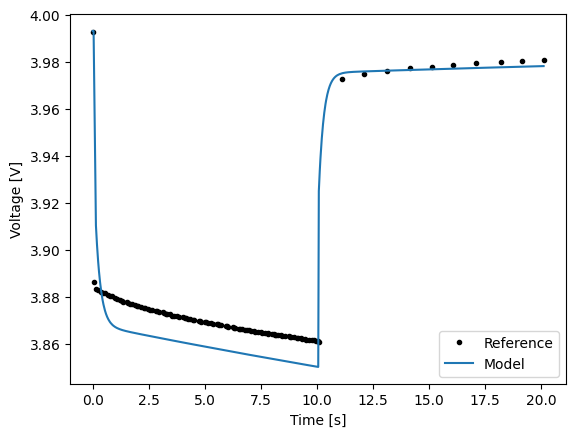

In [ ]:
plt.plot(t_exp, df_pulse_two["Voltage"].values, "k.", label="Reference")

v_ecm = sol["Battery voltage [V]"](sol.t)  # evaluate 0D variable at all time points

plt.plot(sol.t, v_ecm, label="Model")
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.legend()
plt.show()

### Conclusion

As expected, when identifying parameters from a single pulse, extrapolation to different operating conditions is challenging. To address this issue, parameter identification with various pulse datasets is recommended.

This notebook illustrates how to perform circuit model parameter identification using PSO in PyBOP, providing insights into the optimisation process through various visualisations.